# Objectives

1. Learn how to download data directly from WRDS and Compustat
2. Learn how to use SQL to construct characteristic based sorts



#  Form characteristic sorted portfolios

## Example: Returns based sorts: Momentum portfolios

# Momentum


Here is how Daniel and Moskowitz construct their portfolios


To form the momentum portfolios, we first rank stocks based on their cumulative returns
from 12 months before to one month before the formation date (i.e., the t-12 to t-2-month
returns), where, consistent with the literature (Jegadeesh and Titman, 1993, Asness, 1994,
Fama and French, 1996), we use a one month gap between the end of the ranking period and
the start of the holding period to avoid the short-term reversals documented by Jegadeesh
(1990) and Lehmann (1990). 


In particular we will focus on 10% and 90% quantiles of the signal distribution and will construct portfolios of all stocks that are in the bottom and top quantiles



we now have our portfolio composition! 

if equal-weight we just need to invest $1/N_{wP1}$ is any stocks i with wP1i=1 (or wP10i=1) in a given date

where $1/N_{wP1}$  is the number of stocks with wP1=1 in that date. 
So if we have 100 stocks with wP1 =1 in january , you will invest 1/100 of your portoflios in each stock

So the returns on the P1 portfolio are:

$$R_{P1}=\sum_{n=1}^{100}\frac{1}{100}R_n$$

More generally we have

$$R_{Pi,t}=\sum_{n=1}^{N_{t-1}}\frac{wPi_{n,t-1} }{\sum_{n=1}^{N_{t-1}} wPi_{n,t-1}} R_{n,t} $$


# What makes this a valid portfolio?


- Weights are based on information at the time of portfolio formation.

# Constructing Value-Weighted Portfolios

Now we will weight stocks by their market value

Equal-weighted portfolio disproportionally laod on very small stocks

Value-weighted portfolio are much more likely to be tradable

$$R_{Pi,t}=\sum_{n=1}^{N_t}\frac{wPi_{n,t}*MarketCap_{n,t-1} }{\sum_{n=1}^{N_t} wPi_{n,t}*MarketCap_{n,t-1}} R_{n,t} $$

# Why no simply focus on the higher Momentum stock?

## Why construct portfolios?


# Portfolios vs Stocks

 i. Individual stocks have $\sigma$ = 40 − 80%, so $\sigma/\sqrt{T}$ makes it nearly impossible to accurately measure E(R). Portfolios have lower $\sigma$ by diversification.

ii. Betas are badly measured too, and vary over time. 
        
   - example: every firm starts small and risky, but eventually some of then become big and safe
        
iii. You need an interesting alternative. Group stocks together that might have a violation,
this gives much more power.

iv. This is what people do to (try to) make money. They don’t randomly buy stocks.
They buy stocks with certain characteristics that they think will outperform. Thus,
keep tests and practice close.

v. The CAPM seemed fine (and still does) until stocks were grouped by B/M. The
CAPM still works fine for some groupings (size), not others (value) .

But of course you need to know how to form portfolios which characteristcs to use.

And here the sky is the limit, as long you are careful about false discovery!

Examples:

- Stocks talked about in the media
- Stocks of CEOs tweeted by the President
- Stocks with recent deal annoucements
- Stocks with a lot of google search trafic (google trends)
- Stocks with a lot of Tweeter activity
- Stocks that are investing a alot
- Stocks that are very profitable
- Stocks that doing a lot of R&D
- Stocks invested by Famous hedge fund managers
- Stocks invested by less famous managers
- Stokcs invested by Warren Buffet

# The General Recipe

1. Decide on a trading signal (last 12 month return, Book/Market,beta,...)

2. Calculate the trading signal for each stock

3. Group the stocks according to the strengh of the trading signal
    
    - must choose the number of groups, i.e. number of portfolios
    
    - If you choose very few (lets say two), you get the benefit of diversification, but the cost of having only a small spread on the strenght of the trading signal across portfolios
    
    - IF you choose a lot of groups (say 100), you benefit of having a lot of having a large spread in the trading signal
        
        - Portfolio 100 only have really strong stocks
        - Portfolio 1 only really weak stocks
        
    - But there are jsut very few stocks in each portfolio, so you will have a very volatile portfolio    
    
    
4. You have to decide how to weight the stocks within each bin

     - If you value-weight you make more likely that this portfolio can be traded at low cost
     
     - Equal-weighting can sometimes provide more diversification

In [144]:


import pandas as pd
import numpy as np
import datetime as dt
import wrds
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import statsmodels.api as sm

# 1. Download data from WRDS

In [3]:
## GET DATA

# WE will connect with WRDS a data provider aggregator. You can get a password to it by using your rochester email

# we will get data from CRSP , the leading data provider on historical return data. Data is substantially cleaner 
#than bloomberg
# which tends to have a lot of mistakes especially pre 2000

# We will also get data from COMPUSTAT which has data on firms balance-sheets we are incredibly useful to do
#strategies based on fundamentals such as value investing

###################
# Connect to WRDS #
###################
wrdsdo=True # if false get pre downloaded data from dropbox 
if wrdsdo:
    conn=wrds.Connection()

    ###################
    # CRSP Block      #
    ###################
    # The CRSP data set is where you get return data. Here we are tapping into different databasis. Ons is CRSP.msf, 
    #which has monthly retruns, prices, share outstanding. Information about the different fields can be found at:
    # https://wrds-web.wharton.upenn.edu/wrds/ds/crsp/stock_a/msf.cfm?navId=128 

    # the second database in CRSP is CRSP.msenames which has information about the share code, cusip, exchange code, sector
    # of the firm - basically information that is fixed for a given security

    # this code below merges both these data sets using the permno identifier and the criteria that the dates match
    crsp_mo = conn.raw_sql("""
                      select a.permno, a.permco,a.ret, a.vol, a.shrout, a.prc, a.cfacpr, a.cfacshr, a.date, 
                      b.shrcd, b.exchcd, b.siccd, b.ncusip
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2000' and '12/31/2017'
                      and b.shrcd between 10 and 11
                      """) 
else:
    url='https://www.dropbox.com/s/bwjtow60uhdg0vc/crsp19902017.csv?dl=1'
    crsp_m0=pd.read_csv(url,index_col=0)
    
# variables downloaded

# 1. Permno, Permco, ncusip, different types of firm identifiers-- some are firm specific other security specific

# 2. shrco is the type of share: common share, ADR, ETF, ....we will focus on common shares

# 3. exchcd is the code of the exchange where the stock was originally listed

# 4. siccd: Industry code of the firm

# 5. ret, vol, shrout, and prc, are the stock return, trading volume, number of share outstanding, and price

# 6.cfacpr: Cumulative Factor to Adjust Price, allow you to adjust prices for splits 
#   cfacshr: Cumulative Factor to Adjust SHARES, allow you to adjust Shares outstanding for splits 


#7. date is the trading date of the return

#8 .NAMEENDT is a the last effective date of a security's name history structure. 
#It is set to the date preceding the Name Effective Date of the next name structure, the maximum of End of Stock Data, 
#or the Delisting Date of the last name structure.


Enter your WRDS username [Alan Moreira]:moreira5
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [51]:
crsp_mo.tail(10)

,permno,permco,ret,vol,shrout,prc,cfacpr,cfacshr,date,shrcd,exchcd,siccd,ncusip
1788382,92172.0,52520.0,0.024442,44027.0,58586.0,9.64,1.0,1.0,2013-02-28,11.0,1.0,7389.0,25301710
1788383,92172.0,52520.0,0.050830,63394.0,58586.0,10.13,1.0,1.0,2013-03-28,11.0,1.0,7389.0,25301710
1788384,92172.0,52520.0,-0.166831,59567.0,59872.0,8.44,1.0,1.0,2013-04-30,11.0,1.0,7389.0,25301710
1788385,92172.0,52520.0,0.068720,73629.0,59872.0,9.02,1.0,1.0,2013-05-31,11.0,1.0,7389.0,25301710
1788386,92172.0,52520.0,0.021064,54427.0,59872.0,9.21,1.0,1.0,2013-06-28,11.0,1.0,7389.0,25301710
1788387,92172.0,52520.0,-0.058632,52728.0,59044.0,8.67,1.0,1.0,2013-07-31,11.0,1.0,7389.0,25301710
1788388,92172.0,52520.0,-0.039216,36572.0,59044.0,8.33,1.0,1.0,2013-08-30,11.0,1.0,7389.0,25301710
1788389,92172.0,52520.0,0.021609,61037.0,59044.0,8.51,1.0,1.0,2013-09-30,11.0,1.0,7389.0,25301710
1788390,92172.0,52520.0,-0.132785,115973.0,56329.0,7.38,1.0,1.0,2013-10-31,11.0,1.0,7389.0,25301710
1788391,92172.0,52520.0,-0.013550,126445.0,56329.0,7.28,1.0,1.0,2013-11-29,11.0,1.0,7389.0,25301710


In [52]:
crsp_mo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788392 entries, 0 to 1788391
Data columns (total 13 columns):
permno     float64
permco     float64
ret        float64
vol        float64
shrout     float64
prc        float64
cfacpr     float64
cfacshr    float64
date       object
shrcd      float64
exchcd     float64
siccd      float64
ncusip     object
dtypes: float64(11), object(2)
memory usage: 177.4+ MB


## Organize data set and create market value of equity for each firm

In [4]:
# organize CRSP and create market value of equity for each firm


crsp_m=crsp_mo.copy()# create copy so we do not change the original file
crsp_m[['permco','permno','shrcd','exchcd']]=\
    crsp_m[['permco','permno','shrcd','exchcd']].astype(int)# change variable format to integer
crsp_m['date']=pd.to_datetime(crsp_m['date']) # convert to date


# construction of total firm marke cap (need if you want to value weight)
crsp_m['jdate']=crsp_m['date']+MonthEnd(0) # Line up date to be end of month
crsp_m['p']=crsp_m['prc'].abs()/crsp_m['cfacpr'] # price adjusted to splits
crsp_m['tso']=crsp_m['shrout']*crsp_m['cfacshr']*1e3 # total shares out adjusted- reported in thousands
crsp_m['me'] = crsp_m['p']*crsp_m['tso']/1e6 # market cap in $mil

crsp_summe = crsp_m.groupby(['jdate','permco'])['me'].sum().reset_index()\
    .rename(columns={'me':'me_comp'})
# sum of me across different permno belonging to same permco a given date
crsp_m=pd.merge(crsp_m, crsp_summe, how='inner', on=['jdate','permco'])# merge back with the dataset


In [27]:
crsp_m.head()

,permno,permco,ret,vol,shrout,prc,cfacpr,cfacshr,date,shrcd,exchcd,siccd,ncusip,jdate,p,tso,me,me_comp
0,10001,7953,-0.044118,403.0,2450.0,8.125,1.5,1.5,2000-01-31,11,3,4920.0,29274A10,2000-01-31,5.416667,3675000.0,19.90625,19.90625
1,10001,7953,0.038462,326.0,2509.0,10.000,1.5,1.5,2001-03-30,11,3,4920.0,29274A10,2001-03-31,6.666667,3763500.0,25.09000,25.09000
2,10001,7953,-0.025000,286.0,2509.0,9.750,1.5,1.5,2001-04-30,11,3,4920.0,29274A10,2001-04-30,6.500000,3763500.0,24.46275,24.46275
3,10001,7953,0.097436,658.0,2509.0,10.700,1.5,1.5,2001-05-31,11,3,4920.0,29274A10,2001-05-31,7.133333,3763500.0,26.84630,26.84630
4,10001,7953,0.114953,625.0,2513.0,11.800,1.5,1.5,2001-06-29,11,3,4920.0,29274A10,2001-06-30,7.866667,3769500.0,29.65340,29.65340


In [54]:
#########################
# Momentum Factor       #
#########################

# Create (12,1) Momentum Factor with at least 6 months of returns


_tmp_crsp = crsp_m[['permno','date','ret', 'me']].sort_values(['permno','date']).set_index('date')

## Trading siginal construction

_tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)#replace missing return with 0
_tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])#transform in log returns
_tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(12, min_periods=7).sum()# sum last 12 month returns for each 
#stock,require there is a minium of 7 months

_tmp_cumret = _tmp_cumret.reset_index()# reset index, needed to merged back below

_tmp_cumret['cumret']=np.exp(_tmp_cumret['logret'])-1# transform back in geometric  returns


## vol anomaly
## _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(12, min_periods=12).std()
## _tmp_cumret = _tmp_cumret.reset_index()
## _tmp_cumret=_tmp_cumret.rename(columns={'logret':'cumret'})



_tmp_cumret = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
# merge the 12 month return signal back to the original database
_tmp_cumret['mom']=_tmp_cumret.groupby('permno')['cumret'].shift(2) # lag the 12 month signal by two months
# You always have to lag by 1 month to make the stignal tradtable, that is if you are going to use the signal
#to construct a portfolio in the beggining of january/2018, you can only have returns in the signal up to Dec/2017
# we are lagging one more time, because the famous momentum strategy skips a month as well 

# we also labeling mom the trading signal

_tmp_cumret.head(16)

,date,permno,ret,me,logret,cumret,mom
0,1990-01-31,10001,-0.018519,10.156125,-0.018692,NaN,NaN
1,1990-02-28,10001,-0.006289,10.092250,-0.006309,NaN,NaN
2,1990-03-30,10001,0.012658,10.141625,0.012579,NaN,NaN
3,1990-04-30,10001,0.000000,10.141625,0.000000,NaN,NaN
4,1990-05-31,10001,-0.012658,10.013250,-0.012739,NaN,NaN
5,1990-06-29,10001,0.014103,10.052250,0.014004,NaN,NaN
6,1990-07-31,10001,0.025641,10.310000,0.025318,0.014261,NaN
7,1990-08-31,10001,-0.050000,9.794500,-0.051293,-0.036452,NaN
8,1990-09-28,10001,0.040789,10.179000,0.039980,0.002851,0.014261
9,1990-10-31,10001,-0.012821,10.048500,-0.012903,-0.010006,-0.036452


In [55]:

mom=_tmp_cumret.sort_values(['date','permno']).drop_duplicates() # sort by date and firm identifier and drop in case there 
#any duplicates (IT shouldn't be, in a given date for a given firm we can only have one row)
mom['me']=mom.groupby('permno')['me'].shift(1) # lag the market equity that we will use in our trading strategy to construct
# value-weighted returns
mom=mom.dropna(subset=['mom','ret','me'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing

mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))

# create 10 groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
#in a given month 



# transform in string the group names
mom[['mom_group']]='m'+mom[['mom_group']].astype(int).astype(str)
mom.head(24)

,date,permno,ret,me,logret,cumret,mom,mom_group
8,1990-09-28,10001,0.040789,9.794500,0.039980,2.850605e-03,1.426104e-02,m6
339,1990-09-28,10002,-0.127660,6.903125,-0.136576,-1.632653e-01,-2.292552e-09,m6
616,1990-09-28,10003,-0.367347,13.438250,-0.457833,-5.441177e-01,-4.117647e-01,m1
687,1990-09-28,10005,0.666667,0.392625,0.510826,2.500000e-01,-2.500000e-01,m2
705,1990-09-28,10007,-0.464286,3.617250,-0.624154,-9.315069e-01,-8.082192e-01,m0
714,1990-09-28,10009,-0.056604,6.234125,-0.058269,-1.071811e-01,-7.146829e-02,m4
844,1990-09-28,10010,-0.093333,63.384375,-0.097980,2.162791e+00,3.651163e+00,m9
911,1990-09-28,10011,0.222222,26.240625,0.200671,2.013699e+00,1.356164e+00,m9
1008,1990-09-28,10012,-0.173913,3.348656,-0.191055,-2.692308e-01,-1.153846e-01,m4
1195,1990-09-28,10016,-0.114286,237.877500,-0.121361,-2.720197e-01,7.256766e-02,m7


In [56]:

#mom = mom[['permno','gvkey','date','size','mom','group']]

mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
mom=mom.sort_values(['permno','date']) # resort 

# we now have the membership that will go in each portfolio
# withing a given portfolio we will simply use the firms market cap to value-weight the portfolio

# this function takes given date/set of firms given in group, and uses ret_name as the return series and
# weight_name as the variable to be used for weighting

# it returns, on number, the value weighted returns

def wavg(group):
    d = group['ret']
    w = group['me']
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
# We now simply have to  use the above function to construct the portfolio

# the code below applies the function in each date,mom_group group,
# so it applies the function to each of these subgroups of the data set, 
# so it retursn one time-series for each mom_group, as it average the returns of
# all the firms in a given group in a given date
port_vwret = mom.groupby(['date','mom_group']).apply(wavg)
port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires
port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
port_vwret.head(20)

#####

port_vwret
date       mom_group            
1990-09-30 m0          -0.167469
           m1          -0.131829
           m2          -0.112067
           m3          -0.062385
           m4          -0.034503
           m5          -0.035886
           m6          -0.049636
           m7          -0.058958
           m8          -0.049794
           m9          -0.105241
1990-10-31 m0          -0.153056
           m1          -0.079650
           m2          -0.074297
           m3          -0.033160
           m4          -0.009663
           m5          -0.006552
           m6          -0.013150
           m7          -0.002267
           m8           0.000799
           m9          -0.020897

In [57]:
port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
# row the different dates
port_vwret.head()

port_vwret                                                    \
mom_group          m0        m1        m2        m3        m4        m5   
date                                                                      
1990-09-30  -0.167469 -0.131829 -0.112067 -0.062385 -0.034503 -0.035886   
1990-10-31  -0.153056 -0.079650 -0.074297 -0.033160 -0.009663 -0.006552   
1990-11-30   0.161610  0.143733  0.126486  0.116494  0.078180  0.080980   
1990-12-31  -0.060337  0.025289  0.062190  0.051056  0.060526  0.035761   
1991-01-31   0.117182  0.128526  0.122507  0.129375  0.085156  0.055323   

                                                    
mom_group         m6        m7        m8        m9  
date                                                
1990-09-30 -0.049636 -0.058958 -0.049794 -0.105241  
1990-10-31 -0.013150 -0.002267  0.000799 -0.020897  
1990-11-30  0.068891  0.047334  0.058245  0.077298  
1990-12-31  0.053491  0.025727  0.017527  0.019348  
1991-01-31  0.052970  0.029629  0.019195  0.071903

In [58]:
port_vwret=port_vwret.port_vwret # remove the higher index
port_vwret.head()

mom_group,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9
date,,,,,,,,,,
1990-09-30,-0.167469,-0.131829,-0.112067,-0.062385,-0.034503,-0.035886,-0.049636,-0.058958,-0.049794,-0.105241
1990-10-31,-0.153056,-0.079650,-0.074297,-0.033160,-0.009663,-0.006552,-0.013150,-0.002267,0.000799,-0.020897
1990-11-30,0.161610,0.143733,0.126486,0.116494,0.078180,0.080980,0.068891,0.047334,0.058245,0.077298
1990-12-31,-0.060337,0.025289,0.062190,0.051056,0.060526,0.035761,0.053491,0.025727,0.017527,0.019348
1991-01-31,0.117182,0.128526,0.122507,0.129375,0.085156,0.055323,0.052970,0.029629,0.019195,0.071903


In [60]:
port_vwret.mean()/port_vwret.std()*12**0.5

mom_group
m0    0.121454
m1    0.207350
m2    0.426356
m3    0.553081
m4    0.714750
m5    0.845748
m6    0.773298
m7    0.898929
m8    0.714233
m9    0.640551
dtype: float64

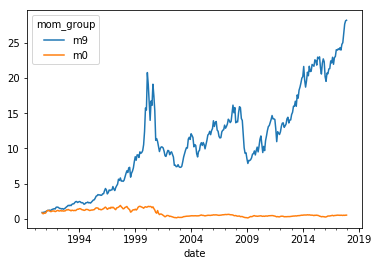

In [61]:
(1+port_vwret[['m9','m0']]).cumprod().plot()

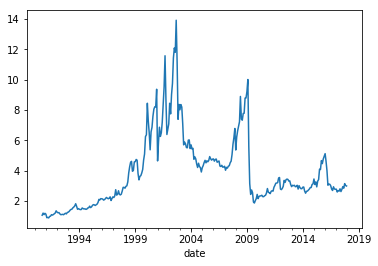

In [41]:
# lets look at the cumulative returns of the momentum strategy
# go long the past winners and short the past loosers

(1+port_vwret['m9']-port_vwret['m0']).cumprod().plot()

Lets make a flexible code that allow us to modify our trading strategy

1. strategy look back period
2. Skip the first month?
3. Weighting criteria: value weighted, equal weighted, volume weighted
4. return transformation: sum? std? min? max?
5. number of portfolios


In [137]:
# Things to generalize
# 1. strategy look back period

def momreturns(data):
    

    _tmp_crsp = data[['permno','date','ret', 'me','vol','prc']].sort_values(['permno','date']).set_index('date')
    _tmp_crsp['volume']=_tmp_crsp['vol']*_tmp_crsp['prc'].abs()*100/1e6 # in million dollars like me
    ## Trading siginal construction
    _tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)#replace missing return with 0
    _tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])#transform in log returns
    _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(12, min_periods=7).sum()# sum last 12 month returns for each 
    #stock,require there is a minium of 7 months
    
    _tmp_cumret = _tmp_cumret.reset_index()# reset index, needed to merged back below

    _tmp_cumret['cumret']=np.exp(_tmp_cumret['logret'])-1# transform back in geometric  returns
    _tmp_cumret = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
    # merge the 12 month return signal back to the original database

    _tmp_cumret['mom']=_tmp_cumret.groupby('permno')['cumret'].shift(2) # lag the 12 month signal by two months
 
    # You always have to lag by 1 month to make the signal tradable, that is if you are going to use the signal
    #to construct a portfolio in the beggining of january/2018, you can only have returns in the signal up to Dec/2017
    # we are lagging one more time, because the famous momentum strategy skips a month as well 

    # we also labeling mom the trading signal
    mom=_tmp_cumret.sort_values(['date','permno']).drop_duplicates() # sort by date and firm identifier and drop in case there 
    #any duplicates (IT shouldn't be, in a given date for a given firm we can only have one row)
    mom['w']=mom.groupby('permno')['me'].shift(1) # lag the market equity that we will use in our trading strategy to construct
   
    # value-weighted returns
    mom=mom.dropna(subset=['mom','ret','me'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
    mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))

    # create 10 groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
    #in a given month 



    # transform in string the group names
    mom[['mom_group']]='m'+mom[['mom_group']].astype(int).astype(str)
    
    mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
    mom=mom.sort_values(['permno','date']) # resort 

    # we now have the membership that will go in each portfolio
    # withing a given portfolio we will simply use the firms market cap to value-weight the portfolio

    # this function takes given date/set of firms given in group, and uses ret_name as the return series and
    # weight_name as the variable to be used for weighting

    # it returns, on number, the value weighted returns

    def wavg(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan
    # We now simply have to  use the above function to construct the portfolio

    # the code below applies the function in each date,mom_group group,
    # so it applies the function to each of these subgroups of the data set, 
    # so it retursn one time-series for each mom_group, as it average the returns of
    # all the firms in a given group in a given date
    port_vwret = mom.groupby(['date','mom_group']).apply(wavg, 'ret','w')
    port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires
    port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
    port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
    port_vwret=port_vwret.port_vwret
    
    return port_vwret

In [70]:
momportfolios=momreturns(crsp_m)
momportfolios.head()

mom_group,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9
date,,,,,,,,,,
2000-09-30,-0.129798,-0.127564,-0.059888,0.010082,-0.000146,-0.010459,-0.020198,-0.062136,-0.015511,-0.148530
2000-10-31,-0.194332,0.015773,-0.002241,0.032663,0.073164,0.002303,-0.013374,-0.024672,-0.052285,-0.083326
2000-11-30,-0.332688,-0.172800,-0.081751,-0.056363,-0.078136,-0.080703,-0.061328,-0.057193,-0.094138,-0.228494
2000-12-31,-0.171986,-0.064771,-0.039219,0.044748,0.081500,-0.018927,0.004215,0.043595,0.020782,0.085389
2001-01-31,0.418080,0.397878,0.302872,0.093824,0.093099,0.084136,-0.014138,-0.010242,-0.046882,-0.069165


In [38]:
momportfolios.mean()*12

mom_group
m0    0.007979
m1    0.034386
m2    0.072522
m3    0.073214
m4    0.092496
m5    0.090398
m6    0.071411
m7    0.093366
m8    0.065737
m9    0.046827
dtype: float64

In [ ]:
#    _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(windown, min_periods=7).apply(func)# sum last 12 month returns for each 
#    momportfolios=momreturns(crsp_m,windown=12,skipmonth=True,func=np.std,nportfolios=10)

# Some insights on Implementation and Liquidity

So we have taken prices as given and discussed quantitative allocation rules that overperform relative to a standard CAPM benchmark.

An important question is wheter we would be able to trade at those prices if we tried to implement the strategy.

Liquidity is the ease of trading a security.

This can be quite complex and encompass many things, all of which impose a cost on those wishing to trade.

Sources of illiquidity:

1. Exogenous transactions costs = brokerage fees, order-processing costs, transaction taxes.

2. Demand pressure = when need to sell quickly, sometimes a buyer is not immediately available (search costs).

3. Inventory risk = if can’t find a buyer will sell to a market maker who will later sell position.  But, since market maker faces future price changes, you must compensate him for this risk.

4. Private information = concern over trading against an informed party (e.g., insider).  Need to be compensated for this. Private information can be about fundamentals or order flow

Obviuosly a perfect answer to this question requires costly experimentation. It would require trading and measuring how prices change in reponse to your trading behavior.

A much simpler approach is to measure the absorption capacity of the strategy.

The idea is to measure how much of the trading volume of each stock you would "use" to implement the strategy for a given position size

Specifically:

$$UsedVolume_{i,t}=\frac{Trading_{i,t}}{Volume_{i,t}}$$

The idea is that if you trade a small share of the volume, you are likely to able to trade at the posted prices.


To compute how much you need to trade you need to compare the desired weights in date $t$ with the weights you have in the end of date $t+1$.

Before trading your weight in date $t+1$ is


$$W_{i,t+1}(before trading)= \frac{W_{i,t}^*position*(1+R_{i,t+1})}{position*(1+R_{t+1}^{strategy})}$$


If the desired position in the stock is $$W_{i,t+1}^*$$, then

$$UsedVolume_{i,t}=position\frac{W_{i,t+1}^*-W_{i,t+1}(before trading)}{Volume_{i,t}}$$

which is


$$UsedVolume_{i,t}=position\frac{W_{i,t+1}^*-\frac{W_{i,t}^*(1+R_{i,t+1})}{1+R_{t+1}^{strategy}}}{Volume_{i,t}}$$


$UsedVolume_{i,t}$ is a stock-time specific statistic. Implementability will depend of how high this quantity is across time and across stocks-- the lower the better. 

If it is very high--i.e. close to  1-- means that your position would require almost all volume in a particular stock. It doesn't mean that you wouldn't be able to trade, but likely prices would move against you (i.e., go up as you buy, do down as you sell)

One vere conservative way of looking at it to look at the maximum of this statistic across stocks. This tell you the "weakest" link in your portfolio formation. 

The max statistic for  is the right one to look at if you are unwilling to deviate from your "wish portfolio".

But the "wish portfolio" does not take into account transaction costs

How can portfolios take into account trading costs to reduce total costs substantially?

Can we change the portfolios to reduce trading costs without altering them significantly?

One simple way of looking at this is to look at the  95/75/50 percentiles of the used volume distribution.

If it declines steeply it might makes sense to avoid the to 5%/25% of the stocks that least liquid in you portfolio

But as you deviate from the original portfolio you will have tracking error relative to the original strategy.


In [94]:

_tmp_crsp = data[['permno','date','ret', 'me','vol','prc']].sort_values(['permno','date']).set_index('date')
_tmp_crsp['volume']=_tmp_crsp['vol']*_tmp_crsp['prc'].abs()*100/1e6 # in million dollars like me
## Trading siginal construction
_tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)#replace missing return with 0
_tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])#transform in log returns
_tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(12, min_periods=7).sum()# sum last 12 month returns for each 
#stock,require there is a minium of 7 months

_tmp_cumret = _tmp_cumret.reset_index()# reset index, needed to merged back below

_tmp_cumret['cumret']=np.exp(_tmp_cumret['logret'])-1# transform back in geometric  returns
_tmp_cumret = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
# merge the 12 month return signal back to the original database

_tmp_cumret['mom']=_tmp_cumret.groupby('permno')['cumret'].shift(2) # lag the 12 month signal by two months

# You always have to lag by 1 month to make the signal tradable, that is if you are going to use the signal
#to construct a portfolio in the beggining of january/2018, you can only have returns in the signal up to Dec/2017
# we are lagging one more time, because the famous momentum strategy skips a month as well 

# we also labeling mom the trading signal
mom=_tmp_cumret.sort_values(['date','permno']).drop_duplicates() # sort by date and firm identifier and drop in case there 
#any duplicates (IT shouldn't be, in a given date for a given firm we can only have one row)
mom['me']=mom.groupby('permno')['me'].shift(1) # lag the market equity that we will use in our trading strategy to construct
# value-weighted returns
mom=mom.dropna(subset=['mom','ret','me'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))

# create 10 groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
#in a given month 



# transform in string the group names
mom[['mom_group']]='m'+mom[['mom_group']].astype(int).astype(str)

mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
mom=mom.sort_values(['permno','date']) # resort 



In [95]:
# lets keep the weights of the strategy

def wavg(group, ret_name, weight_name):
    d = group[ret_name]
    w = group[weight_name]
    try:
        group['Wght']=(w) / w.sum()
        return group[['date','permno','Wght']]
    except ZeroDivisionError:
        return np.nan

weights = mom.groupby(['date','mom_group']).apply(wavg, 'ret','me') 
# merge back
mom=mom.merge(weights,on=['date','permno'])
mom=mom.sort_values(['date','permno'])

# record next month group and weight
mom['mom_group_lead']=mom.groupby('permno').mom_group.shift(-1)
mom['Wght_lead']=mom.groupby('permno').Wght.shift(-1)
mom=mom.sort_values(['permno','date'])

# cosntruct momentum return
def wavg(group, ret_name, weight_name):
    d = group[ret_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
port_vwret = mom.groupby(['date','mom_group']).apply(wavg, 'ret','me')
port_vwret = port_vwret.reset_index().rename(columns={0:'port_ret'})   
# merge back and assing to each stock the return on the portfolio that it belongs at date t
mom=mom.merge(port_vwret,how='left',on=['date','mom_group'])


In [96]:
# construct dollars of each stock that need to be bought (sold) at date t+1
mom['trade']=mom.Wght_lead*(mom.mom_group==mom.mom_group_lead)-mom.Wght*(1+mom.ret)/(1+mom.port_ret)


,date,permno,ret,me,vol,prc,volume,logret,cumret,mom,mom_group,Wght,mom_group_lead,Wght_lead,port_ret,trade,tradepervol
886164,2017-03-31,93436,0.113244,40415.884188,1070387.0,278.299988,29788.868903,0.107279,0.211211,0.317626,m5,0.011031,m5,0.011015,0.004312,-0.001213,-4.070578e-08
886165,2017-04-30,93436,0.128530,45686.839196,1170001.0,314.070007,36746.222264,0.120916,0.304494,0.302506,m5,0.011015,m5,0.012548,0.012163,0.000266,7.232683e-09
886166,2017-05-31,93436,0.085777,51589.139403,1481990.0,341.010010,50537.342437,0.082296,0.527617,0.211211,m5,0.012548,m6,0.015748,0.013820,-0.013438,-2.659060e-07
886167,2017-06-30,93436,0.060409,56014.304204,1859796.0,361.609985,67252.080432,0.058654,0.703458,0.304494,m6,0.015748,m8,0.021759,0.004977,-0.016617,-2.470859e-07
886168,2017-07-31,93436,-0.105473,60339.326986,1816705.0,323.470001,58764.956857,-0.111460,0.377699,0.527617,m8,0.021759,m8,0.019042,0.045066,0.000418,7.104772e-09
886169,2017-08-31,93436,0.100257,53982.938094,1369905.0,355.899994,48754.918114,0.095543,0.678694,0.703458,m8,0.019042,m7,0.020279,0.021983,-0.020500,-4.204783e-07
886170,2017-09-30,93436,-0.041585,59395.082281,1115125.0,341.100006,38036.914431,-0.042474,0.671813,0.377699,m7,0.020279,m9,0.037847,0.024918,-0.018963,-4.985546e-07
886171,2017-10-31,93436,-0.028056,57310.599725,1230312.0,331.529999,40788.533586,-0.028457,0.676680,0.678694,m9,0.037847,m9,0.041168,0.050516,0.006151,1.508133e-07
886172,2017-11-30,93436,-0.068410,55719.252305,1488451.0,308.850006,45970.810043,-0.070863,0.630676,0.671813,m9,0.041168,m8,0.021894,0.017043,-0.037709,-8.202833e-07
886173,2017-12-31,93436,0.008095,51907.493976,1099476.0,311.350006,34232.185931,0.008062,0.457017,0.676680,m8,0.021894,NaN,NaN,0.010414,NaN,NaN


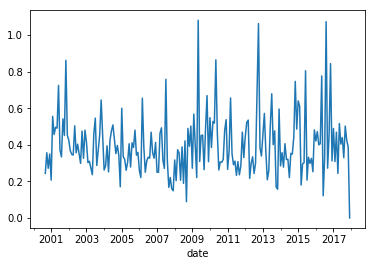

In [125]:
# per dollar of position how much do you have to trade every month?
mom.groupby(['date','mom_group']).trade.apply(lambda x:x.abs().sum()).loc[:,'m9'].plot()

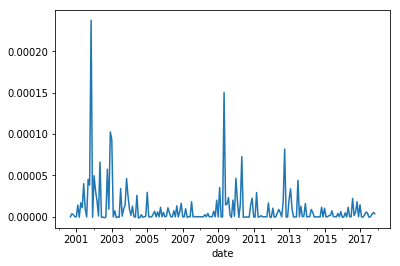

In [120]:
# lets look at the most illiquid stocks, the stocks that I will likely have most trouble trading
# lets start by normalizing the amount of trade per stock volume

mom['tradepervol']=mom.trade/mom.volume




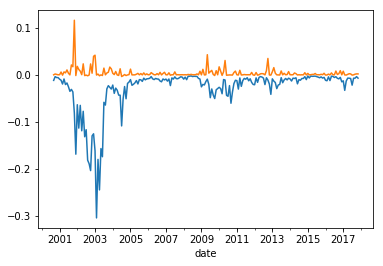

In [133]:
# this allow us to study how much of the volume of each stock I will be "using"
# lets choose a position size, here in millions of dollars , because that is the normalization we used for the volume data
Position=1e3 #(1e3 means one billion dollars)
threshold=0.10
(Position*(mom.groupby(['date','mom_group']).tradepervol.quantile(threshold).loc[:,'m9'])).plot()
(Position*(mom.groupby(['date','mom_group']).tradepervol.quantile(1-threshold).loc[:,'m9'])).plot()

# Tracking error

Let $$W^{wishportfolio}_t$$ and $$W^{Implementationportfolio}_t$$ weights , then consider the following regression

$$W^{Implementationportfolio}_tR_{t+1}=\alpha+\beta W^{wishportfolio}_tR_{t+1}+\epsilon_{t+1}$$

a good implementation portfolio has $\beta=1$ and $\sigma(\epsilon)$ and $\alpha\approx 0$.

So one can think of $|\beta-1|$, $\sigma(\epsilon)$ , and $\alpha$ as three dimensions of tracking error.

The $\beta$ dimension can be more easily correted by levering up and down the tracking portoflio (of possible)

The $\sigma(\epsilon)$ can only be corrected by simply making the implemenetation portoflio more similar to the wish portfolio. The cost of this is not obvious. Really depends how this tracking error relates to other stuff in your portfolio.

$\alpha$ is the important part. The actual cost that you expect to pay to deviate from the wish portfolio

------------------------------

In the industry people typicall refer to tracking error as simply

$$\sigma(W^{Implementationportfolio}_tR_{t+1}- W^{wishportfolio}_tR_{t+1})$$

The volatility of a portfolio that goes long the implementation portfolio and shorts the wish portfolio.

This mixes together $|\beta-1|$, $\sigma(\epsilon)$ and completely ignores $\alpha$


In the end the Implementation portfolio is chosen by trading off  trading costs (market impact) and opportunity cost (tracking error).

So you can simply construct strategies that avoid these 5% less liquid stocks, and see how much your tracking error increases and whether these tracking errors are worth the reduction in trading costs

# How to construct an Implementation portfolio?

- A simple strategy: weight by trading volume -> this make sure that you use the same amount of trading volume across all your positions


- Harder to implement: do not buy stocks that are illiquid now or likely to be illiquid next period. Amounts to add another signal interected to the momentum signal. Only buy if illiquid signal not too strong.

Below we implement the volume-weighted approach


In [164]:
momportfolios=momreturns(crsp_m)
momportfoliosvol=momreturns(crsp_m,w='vol')
momportfolios=momportfolios.merge(momportfoliosvol,left_index=True,right_index=True,suffixes=['_me','_vol'])

In [142]:
momportfolios.head(5)

mom_group,m0_me,m1_me,m2_me,m3_me,m4_me,m5_me,m6_me,m7_me,m8_me,m9_me,m0_vol,m1_vol,m2_vol,m3_vol,m4_vol,m5_vol,m6_vol,m7_vol,m8_vol,m9_vol
date,,,,,,,,,,,,,,,,,,,,
2000-09-30,-0.129798,-0.127564,-0.059888,0.010082,-0.000143,-0.010516,-0.020118,-0.062108,-0.015532,-0.148530,-0.175345,-0.129964,-0.091644,-0.041817,-0.078569,-0.102002,-0.041797,-0.071430,-0.042302,-0.103630
2000-10-31,-0.193803,0.015573,-0.002240,0.051042,0.056879,0.002350,-0.013423,-0.024685,-0.052272,-0.083327,-0.210239,-0.090267,-0.061135,0.007828,0.016559,-0.041332,-0.034236,-0.040717,-0.066250,-0.085599
2000-11-30,-0.331351,-0.173224,-0.081811,-0.055005,-0.079905,-0.080539,-0.063107,-0.054668,-0.094147,-0.228494,-0.356413,-0.238972,-0.194483,-0.136260,-0.164590,-0.146529,-0.169296,-0.106301,-0.155380,-0.284814
2000-12-31,-0.172035,-0.064091,-0.038472,0.062127,0.083423,-0.009017,-0.002741,0.043720,0.020615,0.085389,-0.175550,-0.075602,-0.057293,-0.002820,0.054782,-0.017112,-0.028978,0.044208,0.016709,0.085327
2001-01-31,0.418582,0.397816,0.299617,0.095205,0.093103,0.083798,-0.014023,-0.010242,-0.046882,-0.069165,0.719035,0.468777,0.338653,0.228331,0.165616,0.093876,0.078421,0.021932,0.019839,0.000049


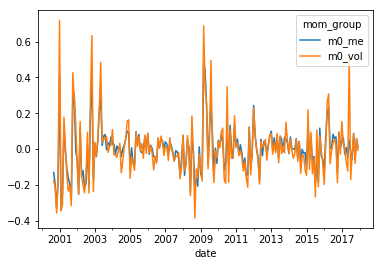

In [143]:
momportfolios[['m0_me','m0_vol']].plot()

In [146]:
# lets look at it's tracking error
y=momportfolios['m9_vol']
x=momportfolios['m9_me']
x=sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 m9_vol   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     1003.
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           4.06e-81
Time:                        08:51:22   Log-Likelihood:                 428.67
No. Observations:                 208   AIC:                            -853.3
Df Residuals:                     206   BIC:                            -846.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.002     -1.051      0.295      -0.007       0.002
m9_me          1.1674      0.037     31.676      0.000       1.095       1.240
==============================================================================
Omnibus:                       39.371   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.213
Skew:                           0.786   Prob(JB):                     1.17e-24
Kurtosis:                       6.201   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations:

- The beta difference 1.16 vs 1 can be adjusted by taking a smaller position on the implementation portfolio

- The alpha is the actual tracking error loss. How much you expect to loose.

- In this case it is economically quite large -0.0023 vs $$\beta E[R]$$ of 0.0045

- It is not statistically significant, but the magnitude is large

- One calculation that people do is to see how much you are getting for your momentum exposure


In [154]:
[momportfolios['m9_vol'].mean()/results.params[1],momportfolios['m9_me'].mean()]

[0.0018945675506737093, 0.003831123463449238]

This is very large. A decay of about 50% in the premium that you earn for trading momentum

But be careful to not over interpret this. We are working today with a very short sample, less than 20 years, for average returns tests that is not much at all.

But beta/residulas are well measured even in fairly short samples.


In addition to that you also have to eat the strategy residual risk

In [155]:
[results.resid.std(),momportfolios['m9_me'].std()]

[0.030886022623588822, 0.05839011395858583]

It is sizable, about 50% of the original strategy volatility

# How our strategies compare with the momentum factor?



In [159]:
url = "https://www.dropbox.com/s/9346pp2iu5prv8s/MonthlyFactors.csv?dl=1"
Factors = pd.read_csv(url,index_col=0, 
                         parse_dates=True,na_values=-99)
Factors=Factors/100

Factors=Factors.iloc[:,0:5]
Factors['MKT']=Factors['MKT']-Factors['RF']
Factors=Factors.drop('RF',axis=1)
Factors.mean()

MKT    0.006567
SMB    0.002101
HML    0.003881
Mom    0.006557
dtype: float64

In [165]:
momportfolios=momportfolios.merge(Factors,left_index=True,right_index=True)
momportfolios.head()

,m0_me,m1_me,m2_me,m3_me,m4_me,m5_me,m6_me,m7_me,m8_me,m9_me,...,m4_vol,m5_vol,m6_vol,m7_vol,m8_vol,m9_vol,MKT,SMB,HML,Mom
2000-09-30,-0.129798,-0.127564,-0.059888,0.010082,-0.000143,-0.010516,-0.020118,-0.062108,-0.015532,-0.148530,...,-0.078569,-0.102002,-0.041797,-0.071430,-0.042302,-0.103630,-0.0545,-0.0140,0.0623,0.0215
2000-10-31,-0.193803,0.015573,-0.002240,0.051042,0.056879,0.002350,-0.013423,-0.024685,-0.052272,-0.083327,...,0.016559,-0.041332,-0.034236,-0.040717,-0.066250,-0.085599,-0.0276,-0.0377,0.0555,-0.0463
2000-11-30,-0.331351,-0.173224,-0.081811,-0.055005,-0.079905,-0.080539,-0.063107,-0.054668,-0.094147,-0.228494,...,-0.164590,-0.146529,-0.169296,-0.106301,-0.155380,-0.284814,-0.1072,-0.0277,0.1129,-0.0244
2000-12-31,-0.172035,-0.064091,-0.038472,0.062127,0.083423,-0.009017,-0.002741,0.043720,0.020615,0.085389,...,0.054782,-0.017112,-0.028978,0.044208,0.016709,0.085327,0.0119,0.0096,0.0730,0.0673
2001-01-31,0.418582,0.397816,0.299617,0.095205,0.093103,0.083798,-0.014023,-0.010242,-0.046882,-0.069165,...,0.165616,0.093876,0.078421,0.021932,0.019839,0.000049,0.0313,0.0656,-0.0488,-0.2501


In [174]:
# things to look at:

#y=momportfolios['m9_me']
#y=momportfolios['m9_vol']
#y=momportfolios['m9_me']-momportfolios['m0_me']


y=momportfolios['m9_me']
x=momportfolios[['MKT','Mom']]
x=sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     387.0
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           2.61e-69
Time:                        09:50:54   Log-Likelihood:                 322.62
No. Observations:                 202   AIC:                            -639.2
Df Residuals:                     199   BIC:                            -629.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.003      0.767      0.444      -0.004       0.010
MKT           -0.2234      0.089     -2.505      0.013      -0.399      -0.048
Mom            1.7587      0.075     23.590      0.000       1.612       1.906
==============================================================================
Omnibus:                       26.262   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.262
Skew:                          -0.182   Prob(JB):                     2.58e-30
Kurtosis:                       7.007   Cond. No.                         28.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

why such a large differcenc even for the strategy that follows the Momentum strategy?

# The devil is in the details: Data Cleaning

Eugene Fama always would tell his students: Garbage in, Garbage out

He was also able to look at a Table of a regression, or summary statistics and immediately tell that the person had 
done something different with the data when cleaning it.


When working with raw data, it is really important to undergo careful work to check if the underlying data is indeed real

CRSP dataset is very clean already, but if you are not careful your analysis will pick up features of the data are not real

- Load on microstructure effects- bid-ask bounces

- Load on tiny/peny stocks

- Load on stocks that are outside of your investment mandate (for example stocks that do not trade in the US)

- Load on other financial instruments (closed-end funds, convertible, prefered shares..)


For example, Daniel and Moskowitz impose the following data requriements


(a). CRSP Sharecode 10 or 11. (i.e, common stocks; no ADRs)

(b). CRSP exchange code of 1, 2 or 3 (NYSE, AMEX or NASDAQ)

(c). Must have price at date t-13

(d). Must have return at date t-2

(e). Must have market cap at date t-1





In [137]:
def momreturns(data,w='me'):
    

    _tmp_crsp = data[['permno','date','ret', 'me','vol','prc']].sort_values(['permno','date']).set_index('date')
    _tmp_crsp['volume']=_tmp_crsp['vol']*_tmp_crsp['prc'].abs()*100/1e6 # in million dollars like me
    ## Trading siginal construction
    _tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)#replace missing return with 0
    _tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])#transform in log returns
    _tmp_cumret = _tmp_crsp.groupby(['permno'])['logret'].rolling(12, min_periods=7).sum()# sum last 12 month returns for each 
    #stock,require there is a minium of 7 months
    
    _tmp_cumret = _tmp_cumret.reset_index()# reset index, needed to merged back below

    _tmp_cumret['cumret']=np.exp(_tmp_cumret['logret'])-1# transform back in geometric  returns
    _tmp_cumret = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
    # merge the 12 month return signal back to the original database

    _tmp_cumret['mom']=_tmp_cumret.groupby('permno')['cumret'].shift(2) # lag the 12 month signal by two months
 
    # You always have to lag by 1 month to make the signal tradable, that is if you are going to use the signal
    #to construct a portfolio in the beggining of january/2018, you can only have returns in the signal up to Dec/2017
    # we are lagging one more time, because the famous momentum strategy skips a month as well 

    # we also labeling mom the trading signal
    mom=_tmp_cumret.sort_values(['date','permno']).drop_duplicates() # sort by date and firm identifier and drop in case there 
    #any duplicates (IT shouldn't be, in a given date for a given firm we can only have one row)
    mom['w']=mom.groupby('permno')[w].shift(1) # lag the market equity that we will use in our trading strategy to construct
   
    # value-weighted returns
    mom=mom.dropna(subset=['mom','ret','me'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
    mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))

    # create 10 groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
    #in a given month 



    # transform in string the group names
    mom[['mom_group']]='m'+mom[['mom_group']].astype(int).astype(str)
    
    mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
    mom=mom.sort_values(['permno','date']) # resort 

    # we now have the membership that will go in each portfolio
    # withing a given portfolio we will simply use the firms market cap to value-weight the portfolio

    # this function takes given date/set of firms given in group, and uses ret_name as the return series and
    # weight_name as the variable to be used for weighting

    # it returns, on number, the value weighted returns

    def wavg(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan
    # We now simply have to  use the above function to construct the portfolio

    # the code below applies the function in each date,mom_group group,
    # so it applies the function to each of these subgroups of the data set, 
    # so it retursn one time-series for each mom_group, as it average the returns of
    # all the firms in a given group in a given date
    port_vwret = mom.groupby(['date','mom_group']).apply(wavg, 'ret','w')
    port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires
    port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
    port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
    port_vwret=port_vwret.port_vwret
    
    return port_vwret